In [ ]:
!pip install unidecode
import re
import nltk
from nltk.util import ngrams
from nltk.corpus import stopwords
import string
from unidecode import unidecode
import pandas as pd
import bz2
import gensim
import warnings
import numpy as np
from gensim.models import word2vec
from sklearn.feature_extraction.text import CountVectorizer
from scipy.spatial import distance
from sklearn.metrics.pairwise import cosine_similarity
from tqdm._tqdm_notebook import tqdm_notebook
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
import nltk
from wordcloud import WordCloud
nltk.download('stopwords')

warnings.filterwarnings('ignore')
tqdm_notebook.pandas()

import matplotlib.pyplot as plt
%matplotlib inline

     |████████████████████████████████| 235 kB 4.1 MB/s 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
#opção 1 -> montar o drive no colab e acessar o arquivo de embedding do drive
from google.colab import drive
drive.mount('/content/drive')

#opção 2 -> fazer download e fazer upload por aqui
#from google.colab import files
#uploaded = files.upload()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%%time
# carregar
##na variável path coloque o caminho do embedding baixado:
path_train = "/content/drive/MyDrive/Colab Notebooks/Linguagem Natural/Dados/train.csv"
path_test = "/content/drive/MyDrive/Colab Notebooks/Linguagem Natural/Dados/test.csv"
path_sample = "/content/drive/MyDrive/Colab Notebooks/Linguagem Natural/Dados/sample_submission.csv"

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 8.11 µs


In [ ]:
train = pd.read_csv(path_train)
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [ ]:
test = pd.read_csv(path_test)
test.head()

,textID,text,sentiment
0,f87dea47db,Last session of the day http://twitpic.com/67ezh,neutral
1,96d74cb729,Shanghai is also really exciting (precisely -...,positive
2,eee518ae67,"Recession hit Veronique Branquinho, she has to...",negative
3,01082688c6,happy bday!,positive
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!,positive


In [ ]:
train.append(test)

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
3529,e5f0e6ef4b,"its at 3 am, im very tired but i can`t sleep ...",NaN,negative
3530,416863ce47,All alone in this old house again. Thanks for...,NaN,positive
3531,6332da480c,I know what you mean. My little dog is sinkin...,NaN,negative
3532,df1baec676,_sutra what is your next youtube video gonna b...,NaN,positive


In [ ]:
train = train[['textID',	'text',	'sentiment']].dropna()

In [ ]:
train.isna().sum()

textID       0
text         0
sentiment    0
dtype: int64

Processamento do texto

In [ ]:
def pre_processamento_texto(corpus): 
  #print('Document')
  #print("#Tokenização")
  corpus_alt = re.findall(r"\w+(?:'\w+)?|[^\w\s]", corpus)
  #lowcase
  corpus_alt = [ t.lower() for t in corpus_alt ]
  #print('remove stopwords')
  english_stops = stopwords.words('english')
  corpus_alt = [t for  t in corpus_alt if t not in english_stops]
  #print('remove numeros')
  corpus_alt = [re.sub(r'\d','',t) for t in  corpus_alt]
  #print('remove pontuação')
  corpus_alt = [t for  t in corpus_alt if t not in string.punctuation]
  #print('remove acentos')
  corpus_alt = [unidecode(t) for t in  corpus_alt]
  corpus_alt = ' '.join(corpus_alt).lower()
  return corpus_alt

In [ ]:
train['text_clean'] = train['text'].progress_apply(lambda x:pre_processamento_texto(str(x)))

  0%|          | 0/27480 [00:00<?, ?it/s]

In [ ]:
train['sentiment'].unique()

array(['neutral', 'negative', 'positive'], dtype=object)

In [ ]:
target = train['sentiment'].replace(['neutral', 'negative', 'positive'],[0, 1, 2])
target.head() 

0    0
1    1
2    1
3    1
4    1
Name: sentiment, dtype: int64

###Word Cloud

In [ ]:
''' Word Cloud Analysis Helper Functions. '''

def create_corpus(target, feature):
    corpus = []
    for x in train[train["sentiment"]==target][feature].str.split():
        for i in x:
            corpus.append(i)
    return corpus

def plot_wordcloud(corpus):
    plt.figure(figsize=(14,5))
    word_cloud = WordCloud(background_color='black', max_font_size=60).generate(" ".join(corpus[:50]))
    plt.imshow(word_cloud)
    plt.axis('off')
    plt.show()
    

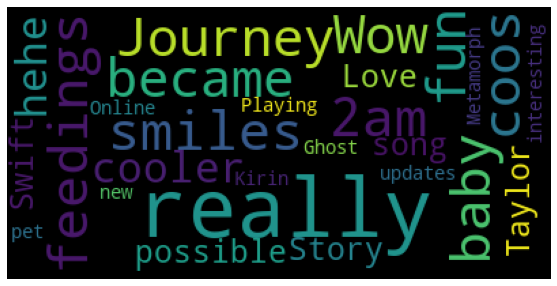

In [ ]:
plot_wordcloud(create_corpus("positive", "text"))

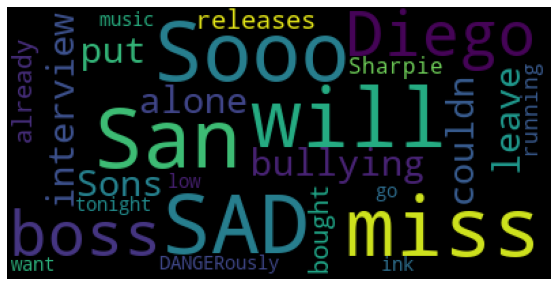

In [ ]:
plot_wordcloud(create_corpus("negative", "text"))

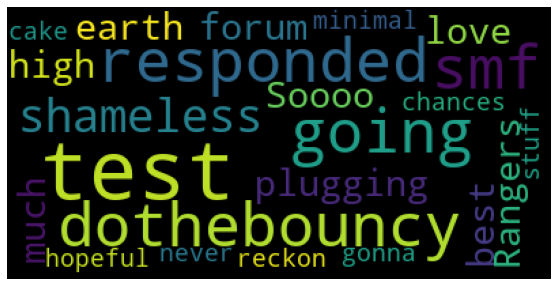

In [ ]:
plot_wordcloud(create_corpus("neutral", "text")) 

In [ ]:
vect_bag = CountVectorizer()

In [ ]:
X_bag = vect_bag.fit_transform(train['text'])

In [ ]:
X_bag

<27480x26439 sparse matrix of type '<class 'numpy.int64'>'
	with 314805 stored elements in Compressed Sparse Row format>

In [ ]:
X_train_bow, X_test_bow, y_train_bow, y_test_bow = train_test_split(X_bag, target,random_state=123)

In [ ]:
modelo_bow = LogisticRegression(intercept_scaling=0)
modelo_bow.fit(X_train_bow,  y_train_bow)

LogisticRegression(intercept_scaling=0)

In [ ]:
y_predi = modelo_bow.predict(X_test_bow)

In [ ]:
print(classification_report(y_test_bow, y_predi))

              precision    recall  f1-score   support

           0       0.64      0.73      0.68      2785
           1       0.70      0.62      0.66      1935
           2       0.78      0.72      0.75      2150

    accuracy                           0.70      6870
   macro avg       0.71      0.69      0.70      6870
weighted avg       0.70      0.70      0.70      6870



In [ ]:
from sklearn.naive_bayes import MultinomialNB
modelo_NB = MultinomialNB()
modelo_NB.fit(X_train_bow,  y_train_bow)

MultinomialNB()

In [ ]:
y_predi = modelo_NB.predict(X_test_bow)

In [ ]:
print(classification_report(y_test_bow, y_predi))

              precision    recall  f1-score   support

           0       0.59      0.70      0.64      2785
           1       0.67      0.56      0.61      1935
           2       0.74      0.67      0.70      2150

    accuracy                           0.65      6870
   macro avg       0.67      0.64      0.65      6870
weighted avg       0.66      0.65      0.65      6870

